In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,15)
plt.rcParams.update({'font.size': 14})

### Q1 - Contrast Stretching

OpenCV does not support contrast stretching directly:
https://stackoverflow.com/questions/42257173/contrast-stretching-in-python-opencv

Displaying images with imshow():
https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad

`pixel_b, pixel_g, pixel_r = image[row][column]`

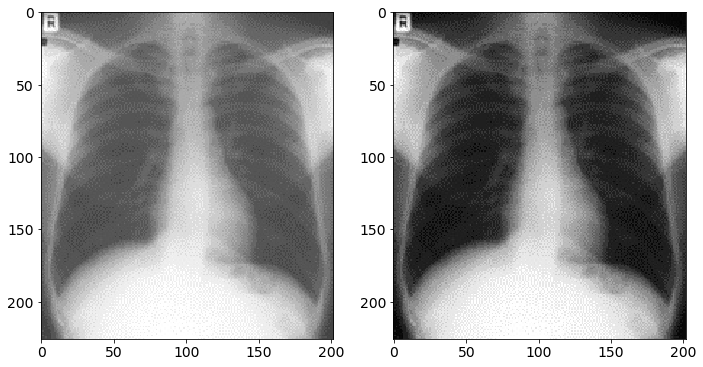

In [122]:
def contrastStretch(img):
    pixel_type = type(img[0][0][0])
    pixel_info = np.iinfo(pixel_type)
    a,b = pixel_info.min, pixel_info.max
    #ndim = img.shape[2] # assume 2D multichannel
    #for channel_index in range(0, ndim):         # unsure on .apply() use
    #channel = img[:,:,channel_index]  
    c,d = np.amin(img), np.amax(img) # min, max present
    #print(a,b,c,d)
    newimg = (img.astype(np.float64) - c) * (b - a)/(d - c) + a
    return newimg.astype(pixel_type)
    
    #newimg = np.zeros(img.shape,dtype=pixel_type)
    #for ri in range(0, img.shape[0]):             # inefficient
    #    for ci in range(0, img.shape[1]):
    #        newimg[ri][ci] = (img[ri][ci] - c) * float(b - a)/(d - c) + a

q1_img = cv2.imread('imageQ1.jpg')
q1_res = contrastStretch(q1_img)
#cv2.imwrite('imageQ1_result.jpg', q1_res)

plt.subplot(1,2,1)
plt.imshow(q1_img)
plt.subplot(1,2,2)
plt.imshow(q1_res)

plt.tight_layout()
plt.show()

### Q2 - Histogram Matching

NOTE: Image pixel intensity results in clipping in matplotlib.pyplot if the image pixels are not of the correct dtype (i.e. uint8_t).

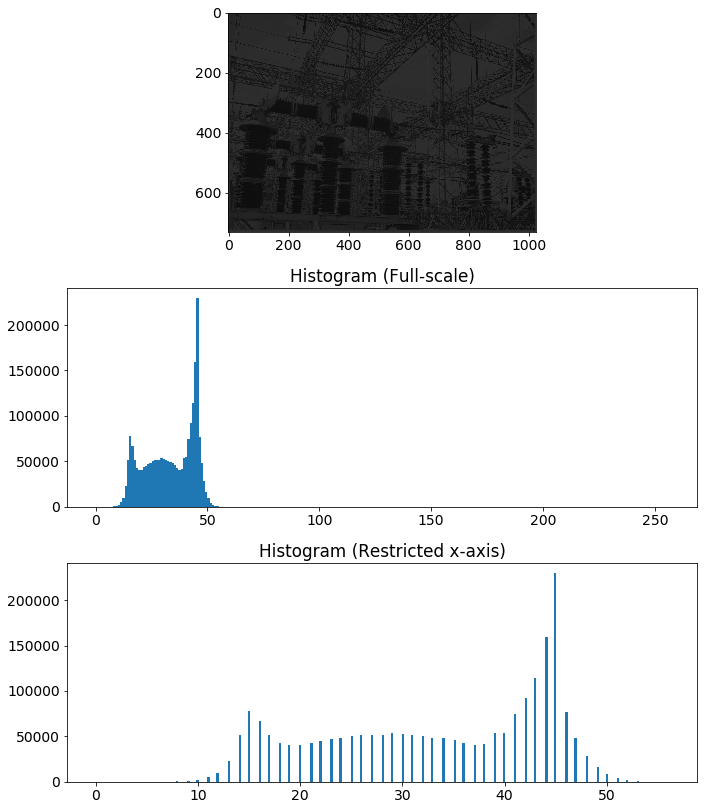

In [123]:
q2_refimg = cv2.imread('imageQ21.jpg')
plt.subplot(4,1,1)
plt.imshow(q2_refimg)

# in-built cv2 histogram function
# https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html
#q2_cvhist = cv2.calcHist([q2_img], [0], None, [256], [0,256]) 
# ^ hard to plot; used more so in generating specialised histogram plots

# matplotlib histogram function
# https://www.datacamp.com/community/tutorials/histograms-matplotlib
plt.subplot(4,1,2)
plt.title('Histogram (Full-scale)')
plt.hist(q2_refimg.ravel(), 256, [0,256]) # full scale

plt.subplot(4,1,3)
plt.title('Histogram (Restricted x-axis)')
q2_refhist = plt.hist(q2_refimg.ravel(), 256, [0,56]) # bins, range

# https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.tight_layout() # stops images overlapping on each other
plt.show()

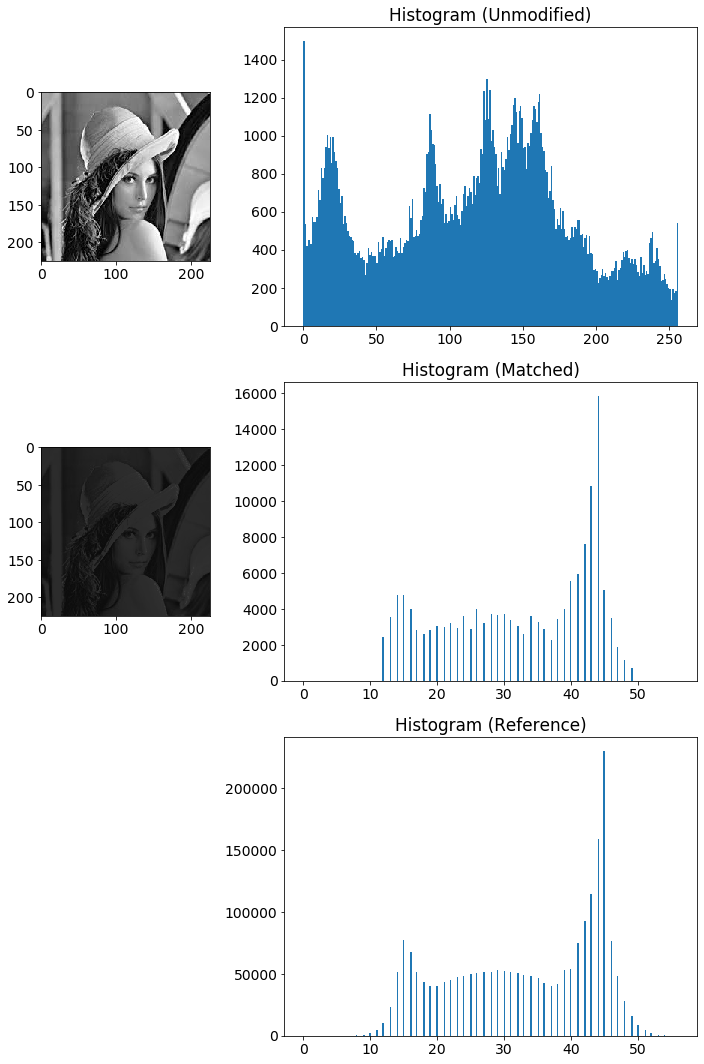

In [124]:
# Question 2.2
# https://theailearner.com/2019/04/10/histogram-matching-specification/

# Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
# Note: function only logically works for greyscale / 1-channel at a time
def hist_match(source, template):
    pixel_type = type(source[0][0][0])
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    # * (can be later reshaped to 2D image if pixel order does not change)

    # get the set of unique pixel values and their corresponding 
    # indices and counts (better than doing a histogram as this tells
    # you where the pixels are located)
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    # * (return_inverse) --> returns indices for that unique value
    #      --> you can reconstruct ar from all the collected indices
    # * (only need to match indexes of src image to template's histogram)
    
    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    # * (cumsum just does a sums of: cur_val + prev_vals, per iteration)
    # * (i.e. from lecture slides, nk(s_counts) / MN(total_pixels))
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(pixel_type)
    # * (vals in a 3 channel greyscale img are triple-counted; seems safe)

    return interp_t_values[bin_idx].reshape(oldshape) # cast back to 2D img

q2_lady = cv2.imread('imageQ22.jpg')
plt.subplot(3,3,1)
plt.imshow(q2_lady)

plt.subplot(3,3,(2,3))
plt.title('Histogram (Unmodified)')
plt.hist(q2_lady.ravel(), 256, [0,256])

q2_newlady = hist_match(q2_lady, q2_refimg)
plt.subplot(3,3,4)
plt.imshow(q2_newlady)

plt.subplot(3,3,(5,6))
plt.title('Histogram (Matched)')
plt.hist(q2_newlady.ravel(), 256, [0,56])

plt.subplot(3,3,(8,9))
plt.title('Histogram (Reference)')
plt.hist(q2_refimg.ravel(), 256, [0,56])

plt.tight_layout()
plt.show()

### Question 3 - Image Filtering (Sobel operator)

matplotlib does not interpret greyscale images very well (no issues with the cv2 image viewer). A solution can be to specify the cmap argument when plotting.

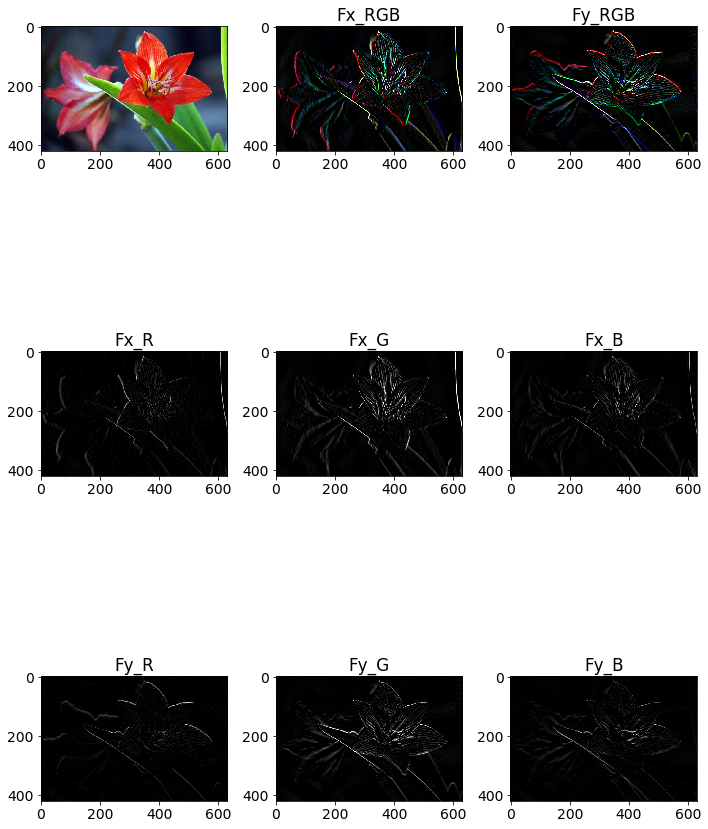

In [155]:
q3_img = cv2.cvtColor(cv2.imread('imageQ3.jpg'), cv2.COLOR_BGR2RGB)

Fx = np.array([ [-1, 0, 1], [-2,0,2], [-1,0,1] ])
Fy = np.array([ [-1,-2,-1], [ 0,0,0], [ 1,2,1] ])

def isolateChannel(img, channel_index): # removes channels
    imgcpy = img.copy()
    for i in range(img.shape[2]): # assume 3 dimensional
        if (i == channel_index):
            continue
        imgcpy[:,:,i] = 0
    return cv2.cvtColor(imgcpy, cv2.COLOR_BGR2GRAY)

q3_isolated = [isolateChannel(q3_img, 0), 
               isolateChannel(q3_img, 1), isolateChannel(q3_img, 2)]
q3_labels = 'RGB'

q3r = 3
q3c = 3
plt.subplot(q3r,q3c,1)
plt.imshow(q3_img)

plt.subplot(q3r,q3c,2)
plt.title('Fx_RGB')
plt.imshow(cv2.filter2D(q3_img, -1, Fx))

plt.subplot(q3r,q3c,3)
plt.title('Fy_RGB')
plt.imshow(cv2.filter2D(q3_img, -1, Fy))

q3_offset = 4
for q3i in range(0,len(q3_isolated)):
    plt.subplot(q3r, q3c, q3i + q3_offset)
    plt.title('Fx_' + q3_labels[q3i])
    plt.imshow(cv2.filter2D(q3_isolated[q3i], -1, Fx), cmap=plt.get_cmap('gray'))

for q3j in range(0,len(q3_isolated)):
    plt.subplot(q3r, q3c, q3j + q3i + q3_offset + 1)
    plt.title('Fy_' + q3_labels[q3j])
    plt.imshow(cv2.filter2D(q3_isolated[q3j], -1, Fy), cmap=plt.get_cmap('gray'))

plt.tight_layout()
plt.show()

In [148]:
# https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/
# * (custom implem. is literally nested-for-loop w. array slicing as the cursor)

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

q3_isolated[0]

array([[ 1,  1,  1, ..., 11, 11, 11],
       [ 1,  1,  1, ..., 12, 12, 12],
       [ 1,  1,  1, ..., 12, 12, 12],
       ...,
       [ 2,  2,  2, ..., 15, 14, 14],
       [ 2,  2,  2, ..., 15, 15, 14],
       [ 2,  2,  2, ..., 15, 15, 14]], dtype=uint8)

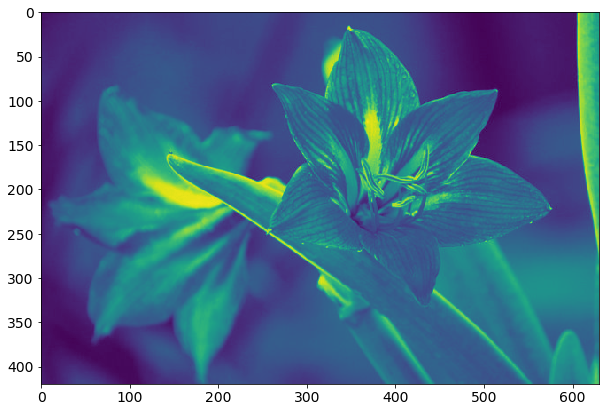